In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

In [2]:
# load data
def load_data(stats_path, wear_path):
    X = pd.read_csv(stats_path).values
    wear_data = pd.read_csv(wear_path)
    y = wear_data[['flute_1', 'flute_2', 'flute_3']].values
    return X, y

In [3]:
# train lasso model with time series split and multi-output regression
def train_lasso(X, y, n_splits=5, alpha=0.1, max_iter=10000):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_errors = []
    val_errors = []
    
    lasso = MultiOutputRegressor(Lasso(alpha=alpha, max_iter=max_iter))

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # normalize the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # train model
        lasso.fit(X_train_scaled, y_train)
        
        # predict
        y_pred_test = lasso.predict(X_test_scaled)
        
        # calculate MSE to evaluate prediction performance
        mse_val = np.mean((y_test - y_pred_test) ** 2, axis=0).mean()
        mse_train = np.mean((y_train - lasso.predict(X_train_scaled)) ** 2, axis=0).mean()
        
        train_errors.append(mse_train)
        val_errors.append(mse_val)

    return lasso, scaler, train_errors, val_errors, list(tscv.split(X))

In [4]:
# prediction based on model
def predict_lasso(lasso, scaler, X):
    X_scaled = scaler.transform(X)
    return lasso.predict(X_scaled)

In [5]:
# plot predictions
def plot_predictions(y_actual, y_pred, title="Wear Prediction", flute_labels=None):
    flute_labels = [f'Flute {i+1}' for i in range(y_actual.shape[1])]
    
    plt.figure(figsize=(24, 9))
    plt.title(title, pad=30)
    
    for i in range(y_actual.shape[1]):
        plt.subplot(1, len(flute_labels), i + 1)
        plt.plot(range(len(y_actual)), y_actual[:, i], label='Actual wear', marker='o', linewidth=6.0)
        plt.plot(range(len(y_pred)), y_pred[:, i], label='Predicted wear', marker='x', linewidth=2.0)
        plt.title(flute_labels[i])
        plt.xlabel('Test sample', labelpad=15)
        plt.ylabel('Wear Measurement')
        plt.legend()
        plt.xticks(rotation=70)
    
    plt.tight_layout(pad=3.0)
    plt.show()

In [6]:
# Function to plot MSE
def plot_mse(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_errors) + 1), train_errors, label='Training MSE', marker='o')
    plt.plot(range(1, len(val_errors) + 1), val_errors, label='Validation MSE', marker='x')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error (MSE) per Fold')
    plt.legend()
    plt.grid(True)
    plt.show()

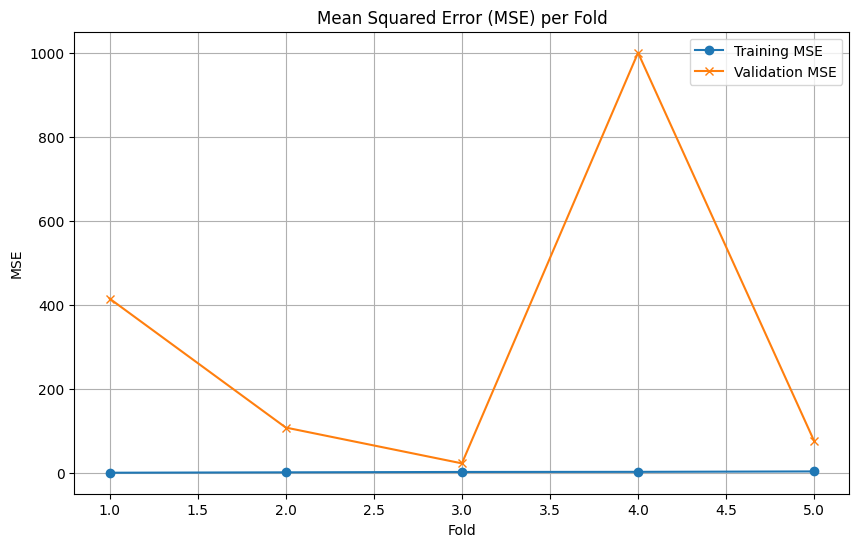

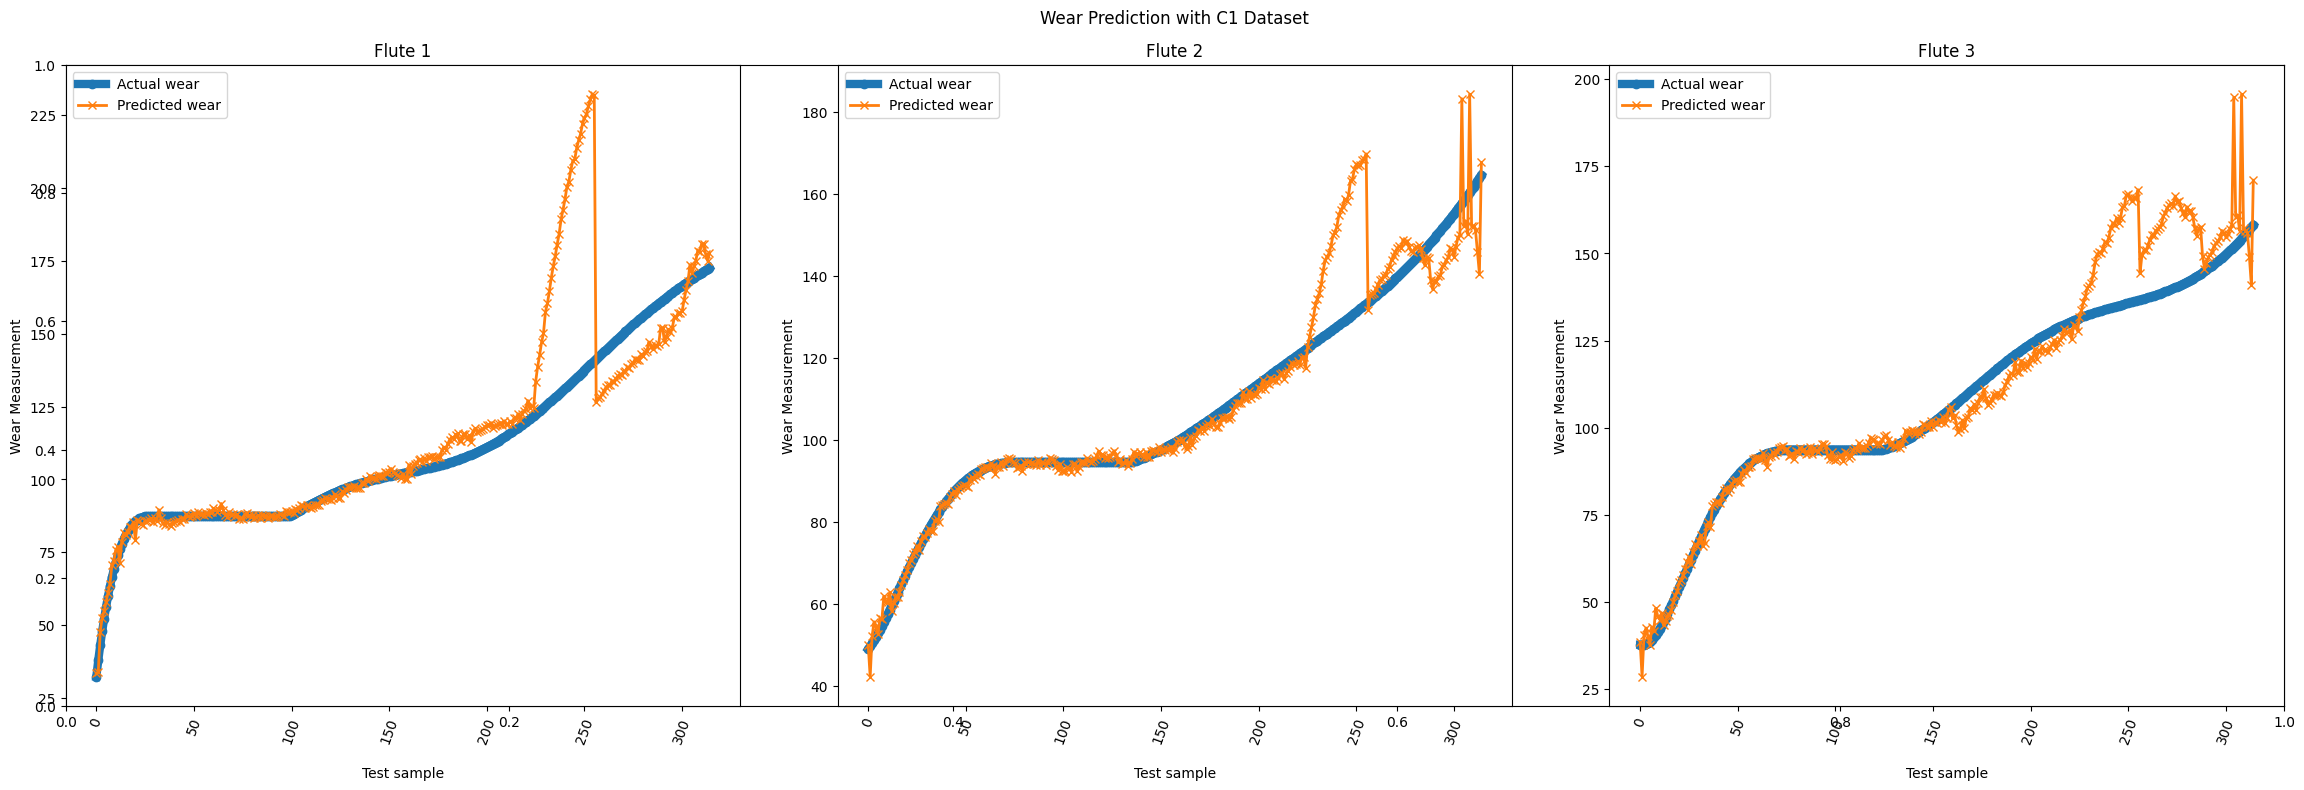

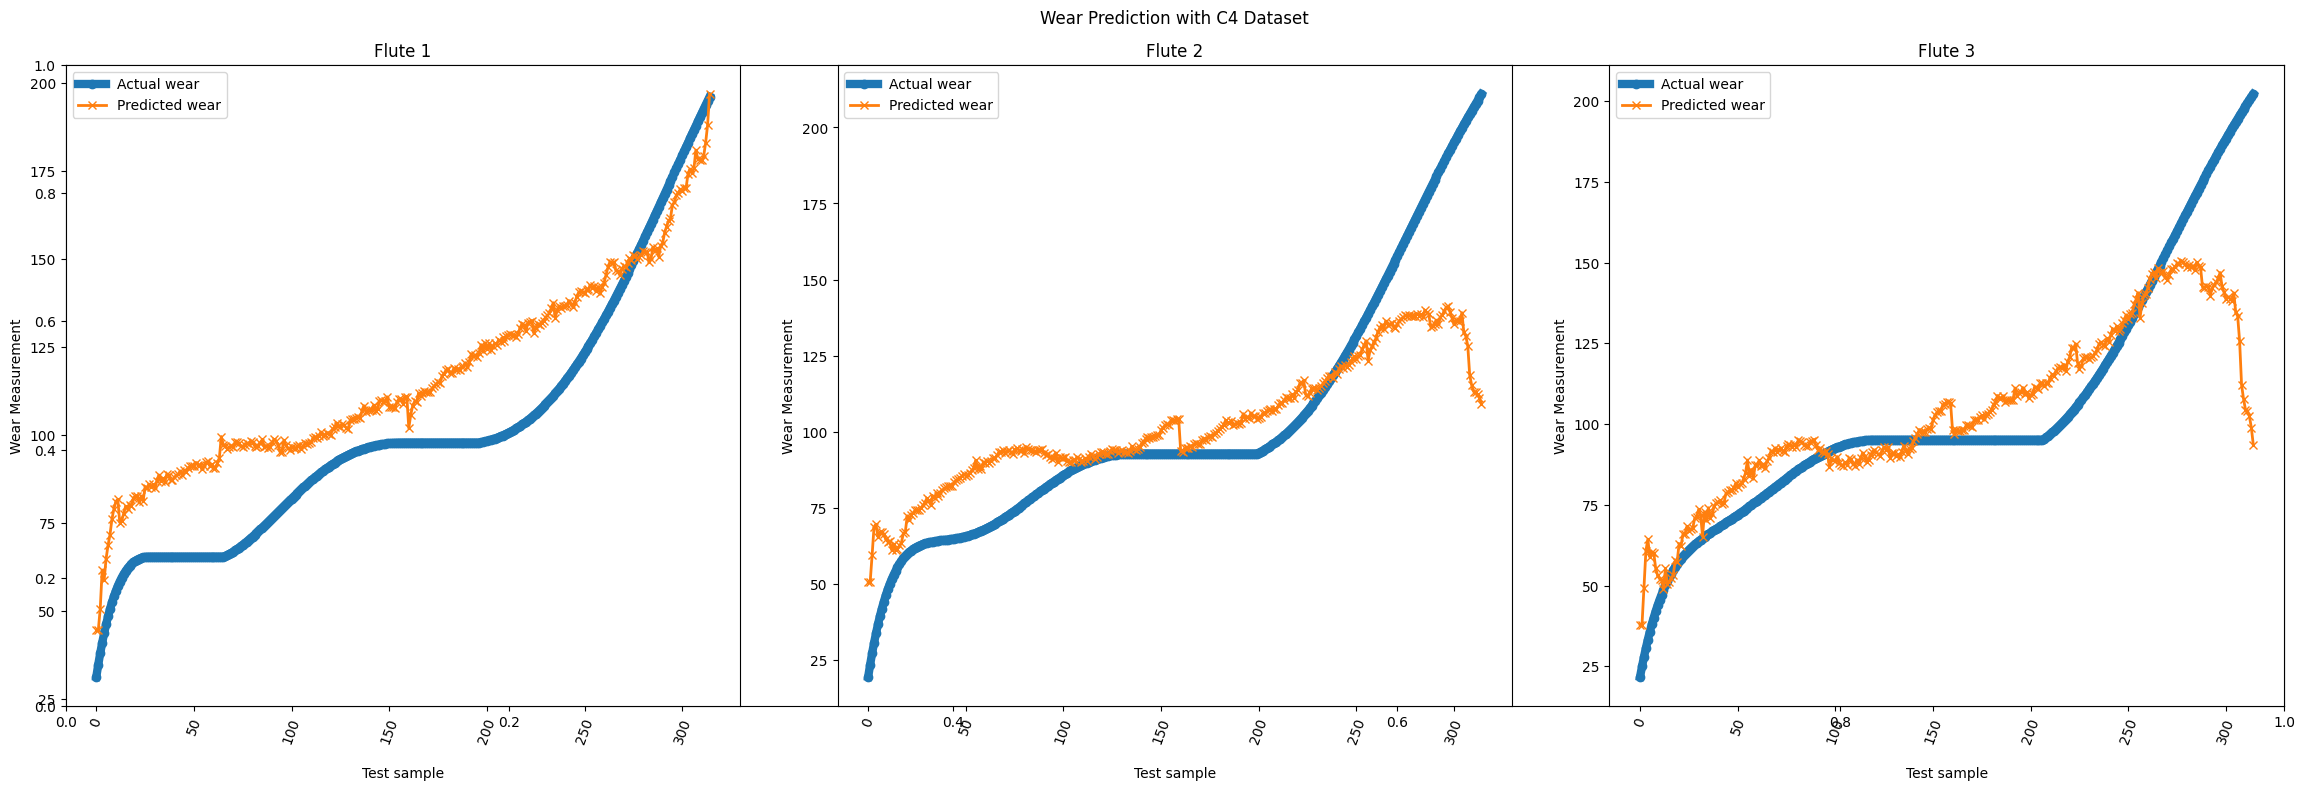

In [7]:
# execution
if __name__ == "__main__":
    # load C1 data
    X, y = load_data('./correlation_files/c1_stats.csv', './data/raw/c1/c1_wear.csv')
    
    # train model
    lasso, scaler, train_errors, val_errors, splits = train_lasso(X, y)

    # plot MSE
    plot_mse(train_errors, val_errors)

    # Use the third fold model for prediction (looked most promising)
    best_split_index = 2
    X_train, X_test = X[splits[best_split_index][0]], X[splits[best_split_index][1]]
    y_train, y_test = y[splits[best_split_index][0]], y[splits[best_split_index][1]]
    
    X_train_scaled = scaler.fit_transform(X_train)
    lasso.fit(X_train_scaled, y_train)

    y_pred = predict_lasso(lasso, scaler, X)

    # plot predictions for C1 data
    plot_predictions(y, y_pred, title="Wear Prediction with C1 Dataset")

    # validate model with C4 data
    X_c4, y_c4 = load_data('../notebooks/correlation_files/c4_stats.csv', '../notebooks/data/raw/c4/c4_wear.csv')
    y_c4_pred = predict_lasso(lasso, scaler, X_c4)
    
    # plot predictions for C4 data
    plot_predictions(y_c4, y_c4_pred, title="Wear Prediction with C4 Dataset")